# Connecting to Database

In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.3.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
!tar xf spark-3.3.0-bin-hadoop2.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.co

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-10-17 18:12:27--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.44MB/s    in 0.6s    

2022-10-17 18:12:28 (1.44 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [4]:
# Salary Data
# Read in data from S3 Buckets
from pyspark import SparkFiles
url="https://group-project-data-bucket.s3.amazonaws.com/clean_salary_data.csv"
spark.sparkContext.addFile(url)
salary_data = spark.read.csv(SparkFiles.get("clean_salary_data.csv"), sep=",", header=True, inferSchema=True)

# Show Dataset
salary_data.show()

+---+----------+-------------------+----------+-----+--------------------+-----------------------+-----------------+--------------+----------+---------------+-------+---------+-------------+-----+
|_c0|responseid|          timestamp|   company|level|               title|totalyearlycompensation|yearsofexperience|yearsatcompany|basesalary|stockgrantvalue|  bonus|rowNumber|         city|state|
+---+----------+-------------------+----------+-----+--------------------+-----------------------+-----------------+--------------+----------+---------------+-------+---------+-------------+-----+
|  0|        A1|2017-06-07 11:33:00|    ORACLE|   L3|     Product Manager|                 127000|              1.5|           1.5|    107000|        20000.0|10000.0|        1| Redwood City|   CA|
|  1|        A2|2017-06-10 17:11:00|      EBAY| SE 2|   Software Engineer|                 100000|              5.0|           3.0|         0|            0.0|    0.0|        2|San Francisco|   CA|
|  2|        A3

In [5]:
# Survey Participants Data
# Read in data from S3 Buckets
from pyspark import SparkFiles
url="https://group-project-data-bucket.s3.amazonaws.com/clean_participants_data.csv"
spark.sparkContext.addFile(url)
participants_data = spark.read.csv(SparkFiles.get("clean_participants_data.csv"), sep=",", header=True, inferSchema=True)

# Show DataFrame
participants_data.show()

+---+----------+-------------------+-------+------------+--------------+----------------+----------------+----------+------------+----------+----------+----------------+----------+-------------+-------+---------+---------+
|_c0|responseid|          timestamp| gender|otherdetails|Masters_Degree|Bachelors_Degree|Doctorate_Degree|Highschool|Some_College|Race_Asian|Race_White|Race_Two_Or_More|Race_Black|Race_Hispanic|   Race|Education|rowNumber|
+---+----------+-------------------+-------+------------+--------------+----------------+----------------+----------+------------+----------+----------+----------------+----------+-------------+-------+---------+---------+
|  0|        A1|2017-06-07 11:33:00|Unknown|     Unknown|             0|               0|               0|         0|           0|         0|         0|               0|         0|            0|Unknown|  Unknown|        1|
|  1|        A2|2017-06-10 17:11:00|Unknown|     Unknown|             0|               0|               0|  

# Preprocessing

## Developing Salary Dataframe for prediction model

In [6]:
#Import dependancies
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [7]:
salary_df = salary_data.toPandas()
salary_df.head() 

,_c0,responseid,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,rowNumber,city,state
0,0,A1,2017-06-07 11:33:00,ORACLE,L3,Product Manager,127000,1.5,1.5,107000,20000.0,10000.0,1,Redwood City,CA
1,1,A2,2017-06-10 17:11:00,EBAY,SE 2,Software Engineer,100000,5.0,3.0,0,0.0,0.0,2,San Francisco,CA
2,2,A3,2017-06-11 14:53:00,AMAZON,L7,Product Manager,310000,8.0,0.0,155000,0.0,0.0,3,Seattle,WA
3,3,A4,2017-06-17 00:23:00,APPLE,M1,Software Engineering Manager,372000,7.0,5.0,157000,180000.0,35000.0,7,Sunnyvale,CA
4,4,A5,2017-06-20 10:58:00,MICROSOFT,60,Software Engineer,157000,5.0,3.0,0,0.0,0.0,9,Mountain View,CA


In [8]:
participants_df = participants_data.toPandas()
participants_df = participants_df.rename(columns={"timestamp": "time", "_c0": "_c02"})
participants_df.head()

,_c02,responseid,time,gender,otherdetails,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,rowNumber
0,0,A1,2017-06-07 11:33:00,Unknown,Unknown,0,0,0,0,0,0,0,0,0.0,0,Unknown,Unknown,1
1,1,A2,2017-06-10 17:11:00,Unknown,Unknown,0,0,0,0,0,0,0,0,0.0,0,Unknown,Unknown,2
2,2,A3,2017-06-11 14:53:00,Unknown,Unknown,0,0,0,0,0,0,0,0,0.0,0,Unknown,Unknown,3
3,3,A4,2017-06-17 00:23:00,Unknown,Unknown,0,0,0,0,0,0,0,0,0.0,0,Unknown,Unknown,7
4,4,A5,2017-06-20 10:58:00,Unknown,Unknown,0,0,0,0,0,0,0,0,0.0,0,Unknown,Unknown,9


In [11]:
# Merge salary and participants tables
salary_df = salary_df.merge(participants_df, left_on='responseid', right_on='responseid')
salary_df.head()

,_c0,responseid,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,...,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,rowNumber_y
0,0,A1,2017-06-07 11:33:00,ORACLE,L3,Product Manager,127000,1.5,1.5,107000,...,0,0,0,0,0,0.0,0,Unknown,Unknown,1
1,1,A2,2017-06-10 17:11:00,EBAY,SE 2,Software Engineer,100000,5.0,3.0,0,...,0,0,0,0,0,0.0,0,Unknown,Unknown,2
2,2,A3,2017-06-11 14:53:00,AMAZON,L7,Product Manager,310000,8.0,0.0,155000,...,0,0,0,0,0,0.0,0,Unknown,Unknown,3
3,3,A4,2017-06-17 00:23:00,APPLE,M1,Software Engineering Manager,372000,7.0,5.0,157000,...,0,0,0,0,0,0.0,0,Unknown,Unknown,7
4,4,A5,2017-06-20 10:58:00,MICROSOFT,60,Software Engineer,157000,5.0,3.0,0,...,0,0,0,0,0,0.0,0,Unknown,Unknown,9


In [12]:
# Information about the dataframe
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52746 entries, 0 to 52745
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   _c0                      52746 non-null  int32         
 1   responseid               52746 non-null  object        
 2   timestamp                52746 non-null  datetime64[ns]
 3   company                  52746 non-null  object        
 4   level                    52746 non-null  object        
 5   title                    52746 non-null  object        
 6   totalyearlycompensation  52746 non-null  int32         
 7   yearsofexperience        52746 non-null  float64       
 8   yearsatcompany           52746 non-null  float64       
 9   basesalary               52746 non-null  int32         
 10  stockgrantvalue          52746 non-null  float64       
 11  bonus                    52746 non-null  float64       
 12  rowNumber_x              52746 n

In [14]:
# Export joined table
salary_df.to_csv('clean_joined_salary_data.csv', index = False)

In [15]:
# Create dataframe with only columns relevant for the prediction model
ml_df = salary_df[['timestamp','company', 'title','totalyearlycompensation', 'yearsofexperience','basesalary','stockgrantvalue','bonus', 'gender', 'Race', 'Education']]
ml_df.head(5)

,timestamp,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,gender,Race,Education
0,2017-06-07 11:33:00,ORACLE,Product Manager,127000,1.5,107000,20000.0,10000.0,Unknown,Unknown,Unknown
1,2017-06-10 17:11:00,EBAY,Software Engineer,100000,5.0,0,0.0,0.0,Unknown,Unknown,Unknown
2,2017-06-11 14:53:00,AMAZON,Product Manager,310000,8.0,155000,0.0,0.0,Unknown,Unknown,Unknown
3,2017-06-17 00:23:00,APPLE,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,Unknown,Unknown,Unknown
4,2017-06-20 10:58:00,MICROSOFT,Software Engineer,157000,5.0,0,0.0,0.0,Unknown,Unknown,Unknown


In [16]:
# Look for missing values
ml_df.isna().sum()

timestamp                  0
company                    0
title                      0
totalyearlycompensation    0
yearsofexperience          0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
Race                       2
Education                  2
dtype: int64

In [17]:
# Add a Year  and quarter column and from timestamp column
ml_df['yearposted'] = pd.DatetimeIndex(ml_df['timestamp']).year
ml_df['yearquarter'] = ml_df['timestamp'].dt.to_period("Q").astype('str')
ml_df = ml_df.drop(['timestamp'], axis = 1)
ml_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,gender,Race,Education,yearposted,yearquarter
0,ORACLE,Product Manager,127000,1.5,107000,20000.0,10000.0,Unknown,Unknown,Unknown,2017,2017Q2
1,EBAY,Software Engineer,100000,5.0,0,0.0,0.0,Unknown,Unknown,Unknown,2017,2017Q2
2,AMAZON,Product Manager,310000,8.0,155000,0.0,0.0,Unknown,Unknown,Unknown,2017,2017Q2
3,APPLE,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,Unknown,Unknown,Unknown,2017,2017Q2
4,MICROSOFT,Software Engineer,157000,5.0,0,0.0,0.0,Unknown,Unknown,Unknown,2017,2017Q2


## Remove rows where base salary equals $0

In [18]:
ml_df = ml_df.loc[ml_df['basesalary'] > 0]

In [19]:
ml_df.head()

,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,gender,Race,Education,yearposted,yearquarter
0,ORACLE,Product Manager,127000,1.5,107000,20000.0,10000.0,Unknown,Unknown,Unknown,2017,2017Q2
2,AMAZON,Product Manager,310000,8.0,155000,0.0,0.0,Unknown,Unknown,Unknown,2017,2017Q2
3,APPLE,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,Unknown,Unknown,Unknown,2017,2017Q2
6,MICROSOFT,Software Engineering Manager,300000,15.0,180000,65000.0,55000.0,Unknown,Unknown,Unknown,2017,2017Q2
7,MICROSOFT,Software Engineer,156000,4.0,135000,8000.0,13000.0,Unknown,Unknown,Unknown,2017,2017Q2


In [20]:
# # Export joined table
from pathlib import Path

if not Path("./Resources").exists():
  print("doesn't exist")
  Path("./Resources").mkdir(exist_ok=True)

ml_df.to_csv('clean_joinced_salary_data.csv', index = False)

### Job Title Column

In [21]:
ml_df['title']

0                     Product Manager
2                     Product Manager
3        Software Engineering Manager
6        Software Engineering Manager
7                   Software Engineer
                     ...             
52741               Software Engineer
52742               Software Engineer
52743               Software Engineer
52744               Software Engineer
52745               Software Engineer
Name: title, Length: 50690, dtype: object

In [22]:
# Filter to only jobs related to Data Scientist and Analyst
ml_df = ml_df[(ml_df.title == "Data Scientist") | (ml_df.title == 'Business Analyst')]
ml_df.head()


,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,gender,Race,Education,yearposted,yearquarter
399,LINKEDIN,Data Scientist,233000,4.0,162000,220000.0,10000.0,Male,Unknown,Unknown,2018,2018Q2
420,MICROSOFT,Data Scientist,218000,11.0,165000,28000.0,23000.0,Male,Unknown,Unknown,2018,2018Q2
432,TWITTER,Data Scientist,500000,4.0,200000,280000.0,20000.0,Male,Unknown,Unknown,2018,2018Q2
466,FACEBOOK,Data Scientist,370000,8.0,190000,140000.0,40000.0,Male,Unknown,Unknown,2018,2018Q2
470,AMAZON,Data Scientist,200000,3.0,150000,105000.0,81000.0,Male,Unknown,Unknown,2018,2018Q2


In [23]:
# Check current information
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 399 to 52727
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  2858 non-null   object 
 1   title                    2858 non-null   object 
 2   totalyearlycompensation  2858 non-null   int32  
 3   yearsofexperience        2858 non-null   float64
 4   basesalary               2858 non-null   int32  
 5   stockgrantvalue          2858 non-null   float64
 6   bonus                    2858 non-null   float64
 7   gender                   2858 non-null   object 
 8   Race                     2858 non-null   object 
 9   Education                2858 non-null   object 
 10  yearposted               2858 non-null   int64  
 11  yearquarter              2858 non-null   object 
dtypes: float64(3), int32(2), int64(1), object(6)
memory usage: 267.9+ KB


## Develop quick insights

### Scatter Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


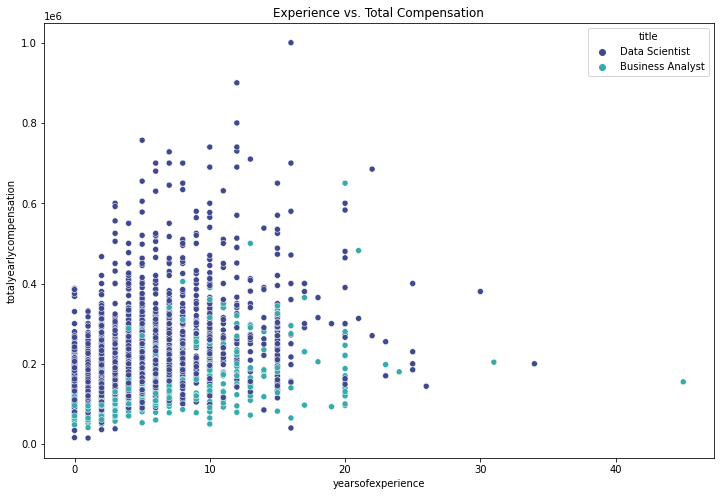

In [24]:
# Years of Experience
plt.figure(figsize=(12,8))
sns.scatterplot('yearsofexperience','totalyearlycompensation', data = ml_df, hue = "title", palette='mako').set(title='Experience vs. Total Compensation')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


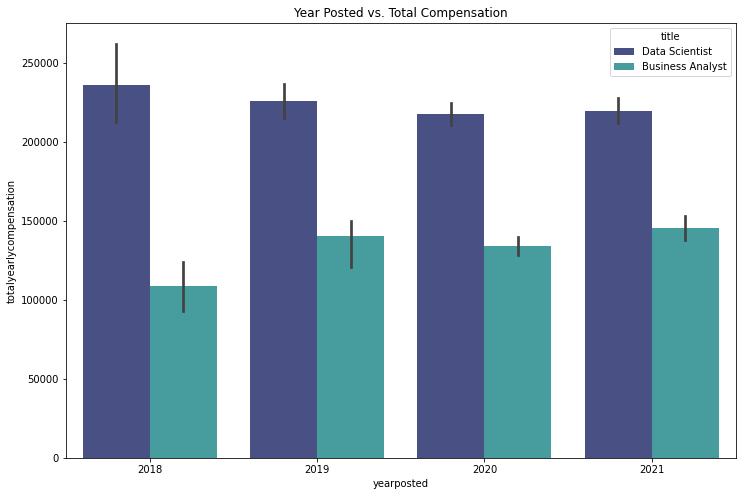

In [25]:
# Year Posted
plt.figure(figsize=(12,8))
sns.barplot('yearposted','totalyearlycompensation', data = ml_df, hue = "title", palette='mako').set(title='Year Posted vs. Total Compensation')
plt.show()

### BoxPlot

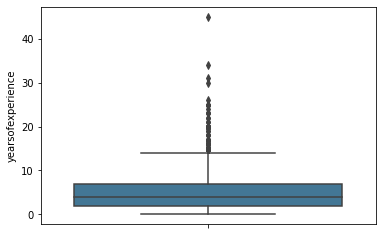

In [26]:
# From the years of experience scatter plot we see that there are some outliers
sns.boxplot(data = ml_df, y = "yearsofexperience",palette = "mako")

In [27]:
# finding the 1st quartile
q1 = np.quantile(ml_df.yearsofexperience, 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(ml_df.yearsofexperience, 0.75)
med = np.median(ml_df.yearsofexperience)
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

5.0 14.5 -5.5


In [28]:
#Finding Outliers
outliers = ml_df[(ml_df.yearsofexperience <= lower_bound) | (ml_df.yearsofexperience >= upper_bound)]
print('The following are the outliers in the boxplot:{}'.format(outliers))

The following are the outliers in the boxplot:                company             title  totalyearlycompensation  \
1503         SALESFORCE    Data Scientist                   315000   
1680          MICROSOFT    Data Scientist                   216000   
3476          MICROSOFT    Data Scientist                   365000   
5398           FACEBOOK    Data Scientist                   395000   
7479          MICROSOFT    Data Scientist                   350000   
...                 ...               ...                      ...   
50730            GOOGLE  Business Analyst                   275000   
50938  PROCTER & GAMBLE  Business Analyst                   128000   
51604       BIGCOMMERCE    Data Scientist                   217000   
51707          FACEBOOK    Data Scientist                   700000   
52635            GOOGLE    Data Scientist                   685000   

       yearsofexperience  basesalary  stockgrantvalue    bonus   gender  \
1503                15.0      225000  

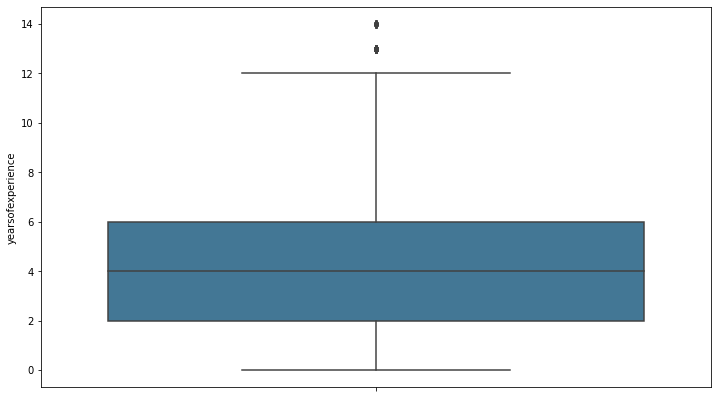

In [29]:
# Eliminating outliers
ml_df = ml_df[(ml_df.yearsofexperience >= lower_bound) & (ml_df.yearsofexperience <= upper_bound)]
plt.figure(figsize=(12, 7))
sns.boxplot(data = ml_df, y='yearsofexperience', palette = "mako")
plt.show()

In [30]:
# Check updated dataframe
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2730 entries, 399 to 52727
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  2730 non-null   object 
 1   title                    2730 non-null   object 
 2   totalyearlycompensation  2730 non-null   int32  
 3   yearsofexperience        2730 non-null   float64
 4   basesalary               2730 non-null   int32  
 5   stockgrantvalue          2730 non-null   float64
 6   bonus                    2730 non-null   float64
 7   gender                   2730 non-null   object 
 8   Race                     2730 non-null   object 
 9   Education                2730 non-null   object 
 10  yearposted               2730 non-null   int64  
 11  yearquarter              2730 non-null   object 
dtypes: float64(3), int32(2), int64(1), object(6)
memory usage: 255.9+ KB


### Correlation Heatmap

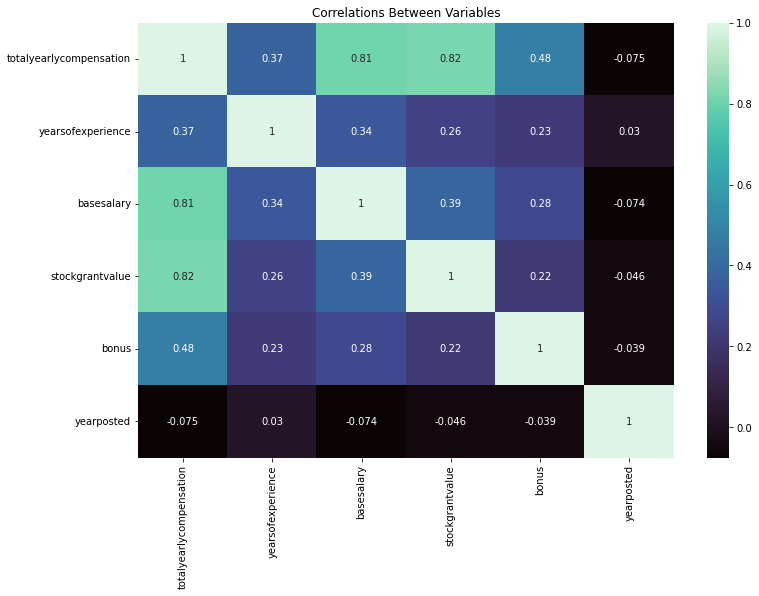

In [31]:
#Look at correlation between total compensation and other variables
plt.figure(figsize=(12,8))
sns.heatmap(ml_df.corr(), cmap="mako", annot = True)
plt.title("Correlations Between Variables")
plt.show()

# Machine Learning Model

In [32]:
# Import dependancies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics  import accuracy_score, explained_variance_score, mean_squared_error, confusion_matrix, r2_score

## Split the Data into Training and Testing

In [33]:
# Add dummies data for categorical variables and drop non-beneficiary columns
df = pd.get_dummies(ml_df.drop(["company", "yearquarter", "gender", "Race", "Education"], axis = 1))

In [34]:
df.head()

,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,yearposted,title_Business Analyst,title_Data Scientist
399,233000,4.0,162000,220000.0,10000.0,2018,0,1
420,218000,11.0,165000,28000.0,23000.0,2018,0,1
432,500000,4.0,200000,280000.0,20000.0,2018,0,1
466,370000,8.0,190000,140000.0,40000.0,2018,0,1
470,200000,3.0,150000,105000.0,81000.0,2018,0,1


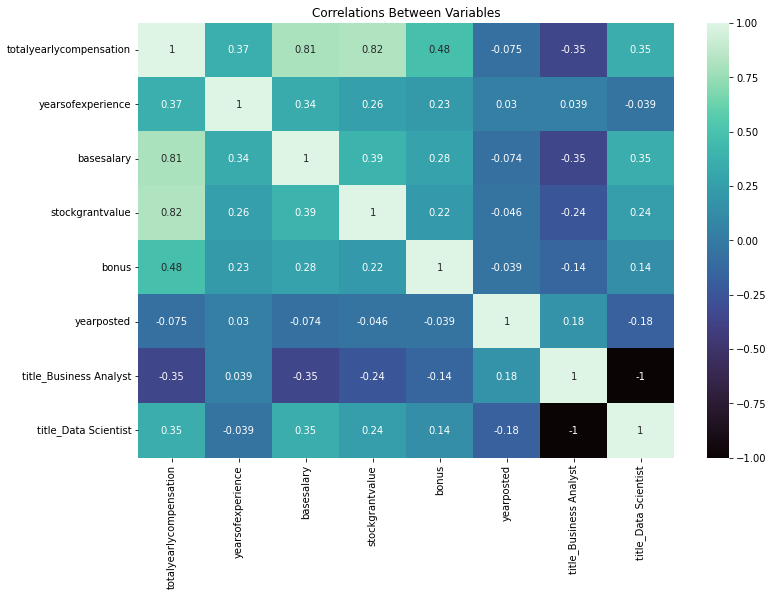

In [35]:
# Check correlation
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="mako", annot = True)
plt.title("Correlations Between Variables")
plt.show()

Because of the high correlation between stock grant value, bonus,  and base salary with our target variable, total compensation. I decided to use only one of the said independent variables to reduce changes of prediction leakage.

I chose the base salary variable because this is information we can usually find pretty easily. When discussing salary negotiation in an interview, is better to understand what is the total compensation instead of the base salary since it takes into account other benefits.

In [36]:
# Define the target and independent features
#Independent Variables
X = df.drop(["totalyearlycompensation", "stockgrantvalue", "bonus"], axis = 1)

# Target Variables
y = df["totalyearlycompensation"]

In [37]:
X.describe()

,yearsofexperience,basesalary,yearposted,title_Business Analyst,title_Data Scientist
count,2730.000000,2730.000000,2730.00000,2730.000000,2730.000000
mean,4.593773,141434.432234,2020.22967,0.252381,0.747619
std,3.251208,52688.582808,0.78996,0.434458,0.434458
min,0.000000,13000.000000,2018.00000,0.000000,0.000000
25%,2.000000,110000.000000,2020.00000,0.000000,0.000000
50%,4.000000,140000.000000,2020.00000,0.000000,1.000000
75%,6.000000,160000.000000,2021.00000,1.000000,1.000000
max,14.000000,700000.000000,2021.00000,1.000000,1.000000


In [38]:
# Split dataset in training and testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape

(2184, 5)

In [39]:
# Scale data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Multilinear Regression

In [40]:
# Create a linear model
multi_model = LinearRegression()
# Fit (train) model to the data
multi_model.fit(X_train, y_train)
# Use model to predict a value
predictions = multi_model.predict(X_test)
print(predictions.shape)

(546,)


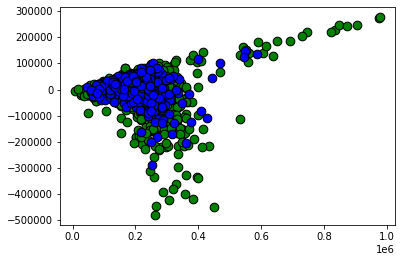

In [41]:
# Plot Residuals
## plotting residual errors in training data
plt.scatter(multi_model.predict(X_train), multi_model.predict(X_train) - y_train,
            color = "green", s = 75, label = 'Train data', edgecolors='black')
  
## plotting residual errors in test data
plt.scatter(multi_model.predict(X_test), multi_model.predict(X_test) - y_test,
            color = "blue", s = 75, label = 'Test data', edgecolors='black')

plt.show()
  

In [42]:
# Model Metrics
r2 = r2_score(y_test, predictions)
# accuracy = accuracy_score(y_test.to_numpy(), predictions)
expl_mlr = explained_variance_score(predictions,y_test)
print(f"R-squared (R2): {r2}")
print(f"Explained Variance: {expl_mlr}")

R-squared (R2): 0.7352217272652555
Explained Variance: 0.6088776855209193


## Random Forest Classifier

In [43]:
# Create a linear model
rf_model = RandomForestRegressor(n_estimators=28,random_state=0)
# Fit (train) model to the data
rf_model.fit(X_train_scaled, y_train)
# Use model to predict a value
predictions = rf_model.predict(X_test_scaled)
print(predictions.shape)

(546,)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


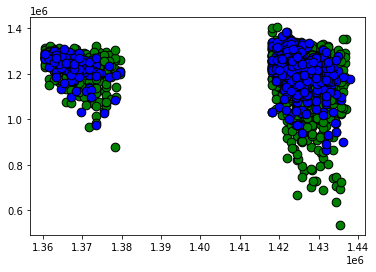

In [44]:
# Plot Residuals
## plotting residual errors in training data
plt.scatter(multi_model.predict(X_train_scaled), multi_model.predict(X_train_scaled) - y_train,
            color = "green", s = 75, label = 'Train data', edgecolors='black')
  
## plotting residual errors in test data
plt.scatter(multi_model.predict(X_test_scaled), multi_model.predict(X_test_scaled) - y_test,
            color = "blue", s = 75, label = 'Test data', edgecolors='black')


In [45]:
# Model Metrics
r2 = r2_score(y_test, predictions)
# accuracy = accuracy_score(y_test.to_numpy(), predictions)
expl_mlr = explained_variance_score(predictions,y_test)
print(f"R-squared (R2): {r2}")
print(f"Explained Variance: {expl_mlr}")

R-squared (R2): 0.7360859703297589
Explained Variance: 0.7332957563190178
